<a href="https://colab.research.google.com/github/kumarmohit0911/Breast_cancer_detector_model/blob/main/Breast_cancer_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
import json, os

kaggle_creds = {
    "username": "kumarmohit0911",
    "key": "KGAT_70d781b0a7eed54b863a6bcb5ab50e9c"
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_creds, f)

os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("kaggle.json created successfully")


kaggle.json created successfully


In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
 99% 3.08G/3.10G [00:30<00:00, 56.6MB/s]
100% 3.10G/3.10G [00:30<00:00, 108MB/s] 


In [5]:
!unzip -q breast-histopathology-images.zip

In [6]:
import os
DATA_DIR = "IDC_regular_ps50_idx5"

image_path = []
labels = []

for patient_id in os.listdir(DATA_DIR):
  patient_path = os.path.join(DATA_DIR,patient_id)
  if not os.path.isdir(patient_path):
    continue

  for label in ["0","1"]:
    label_path = os.path.join(patient_path,label)
    if not os.path.isdir(label_path):
      continue

    for image_name in os.listdir(label_path):
      image_path.append(os.path.join(label_path,image_name))
      labels.append(int(label))


In [7]:
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image

my_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.5,contrast=0.5),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()

])

In [8]:
from torch.utils.data import Dataset
from PIL import Image
class CustomDataset(Dataset):
  def __init__(self,image_path,labels,transforms=my_transform):
    #convert to pytorch tensors
    self.image_path = image_path
    self.labels = labels
    self.transforms = transforms
  def __len__(self):
    return len(self.image_path)

  def __getitem__(self,index):
        # 1. Load image from disk
        image = Image.open(self.image_path[index]).convert("RGB")
        # image = np.stack([image]*3,axis = -1)

        # 2. Get label
        label = self.labels[index]
        if self.transforms:
          image=self.transforms(image)

        return image, label

In [9]:
dataset = CustomDataset(image_path,labels)

In [11]:
from torch.utils.data import random_split
import random
random.seed(42)
# random.shuffle(image_path)

dataset_size = len(dataset)
train_size = int(0.008 * dataset_size)
test_size = dataset_size - train_size

train_dataset,test_dataset = random_split(dataset,[train_size,test_size])

In [12]:
type(train_dataset)

torch.utils.data.dataset.Subset

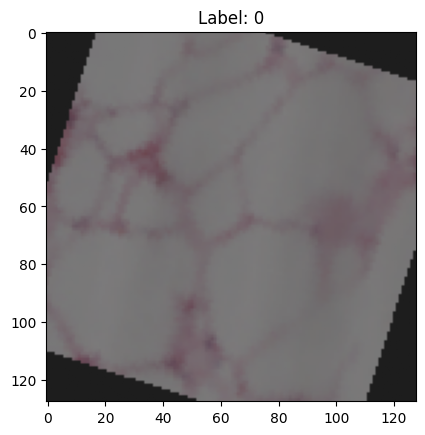

In [13]:
image,label = train_dataset[10]
plt.title(f"Label: {label}")
plt.imshow(image.permute(1,2,0))

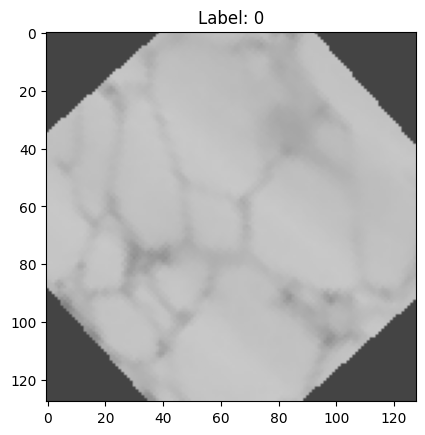

In [14]:
image,label = train_dataset[10]
plt.title(f"Label: {label}")
plt.imshow(image.permute(1,2,0))

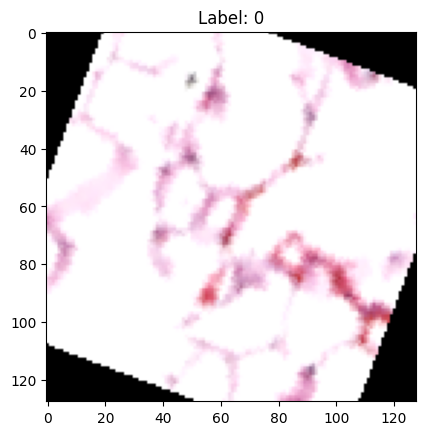

In [15]:
image,label = train_dataset[11]
plt.title(f"Label: {label}")
plt.imshow(image.permute(1,2,0))

In [16]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset,batch_size = 32,shuffle = True,pin_memory = True)
test_loader = DataLoader(test_dataset,batch_size = 32,shuffle = False,pin_memory = True)

In [17]:
#define NN class
class MyNN(nn.Module):
  def __init__(self,num_features):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(num_features,32,kernel_size = 3, padding = "same"),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2,stride = 2),

        nn.Conv2d(32,64,kernel_size = 3, padding = "same"),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2,stride = 2),
        nn.MaxPool2d(2,2)

    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*16*16,128),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(64,8),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(8,2)
    )

  def forward(self,x):
    x = self.features(x)
    x=self.classifier(x)

    return x

In [21]:
# set learning rate and epochs
learning_rate = 1e-3
epochs = 50
#instantiate model
model = MyNN(3)
#loss function
criterion = nn.CrossEntropyLoss()
#optimizer
optimizer = optim.Adam(model.parameters(),lr = learning_rate)


In [ ]:
#training_loop
for epoch in range(epochs):
  for img,lbl in train_loader:
    running_loss = 0
    # forwrds pass
    output = model(img)
    # calculate Loss
    loss = criterion(output,lbl)
    #back pass
    optimizer.zero_grad()
    loss.backward()
    #update grads
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")



Epoch 1/50, Loss: 0.0092
Epoch 2/50, Loss: 0.0099
Epoch 3/50, Loss: 0.0065
Epoch 4/50, Loss: 0.0050
Epoch 5/50, Loss: 0.0063
Epoch 6/50, Loss: 0.0073
Epoch 7/50, Loss: 0.0065
Epoch 8/50, Loss: 0.0084
Epoch 9/50, Loss: 0.0058
Epoch 10/50, Loss: 0.0081
Epoch 11/50, Loss: 0.0057
Epoch 12/50, Loss: 0.0040
Epoch 13/50, Loss: 0.0072
Epoch 14/50, Loss: 0.0052
Epoch 15/50, Loss: 0.0143
Epoch 16/50, Loss: 0.0095
Epoch 17/50, Loss: 0.0069
Epoch 18/50, Loss: 0.0061
Epoch 19/50, Loss: 0.0089
Epoch 20/50, Loss: 0.0061
Epoch 21/50, Loss: 0.0038
Epoch 22/50, Loss: 0.0053
Epoch 23/50, Loss: 0.0072
Epoch 24/50, Loss: 0.0117
Epoch 25/50, Loss: 0.0057
Epoch 26/50, Loss: 0.0086
Epoch 27/50, Loss: 0.0083
Epoch 28/50, Loss: 0.0081
Epoch 29/50, Loss: 0.0127
Epoch 30/50, Loss: 0.0082
Epoch 31/50, Loss: 0.0070
Epoch 32/50, Loss: 0.0074
Epoch 33/50, Loss: 0.0063
Epoch 34/50, Loss: 0.0060
Epoch 35/50, Loss: 0.0050
Epoch 36/50, Loss: 0.0112
Epoch 37/50, Loss: 0.0091
Epoch 38/50, Loss: 0.0076
Epoch 39/50, Loss: 0.

In [23]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [24]:
train_acc = evaluate(model, train_loader)
test_acc = evaluate(model, test_loader)

print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 